# Time series forecasting with arima and sarima

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
plt.style.use('fivethirtyeight')
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error

# The data

### Australia monthly beer production

### Choose data

In [2]:
df = pd.read_csv('monthly-beer-production-in-austr.csv')
df['Date'] = pd.to_datetime(df['Month'])
df = df.drop('Month',1)
df = df[df.Date > '1959-12-01']
df = df[df.Date < '1973-01-01']
df.set_index('Date', inplace=True)
df

,Monthly beer production
Date,
1960-01-01,97.1
1960-02-01,93.0
1960-03-01,96.0
1960-04-01,80.5
1960-05-01,76.1
...,...
1972-08-01,127.8
1972-09-01,143.6
1972-10-01,157.6


### in a graph

<function matplotlib.pyplot.show(*args, **kw)>

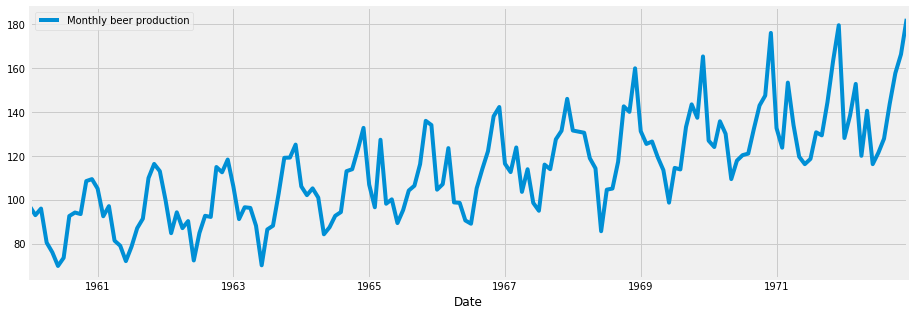

In [3]:
df.plot(figsize=(14,5))
plt.show

### Decompose the data

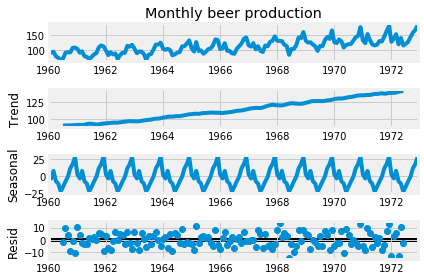

In [4]:
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df['Monthly beer production'], freq=12)
decomposition.plot()
plt.show()

### Observe the correlation

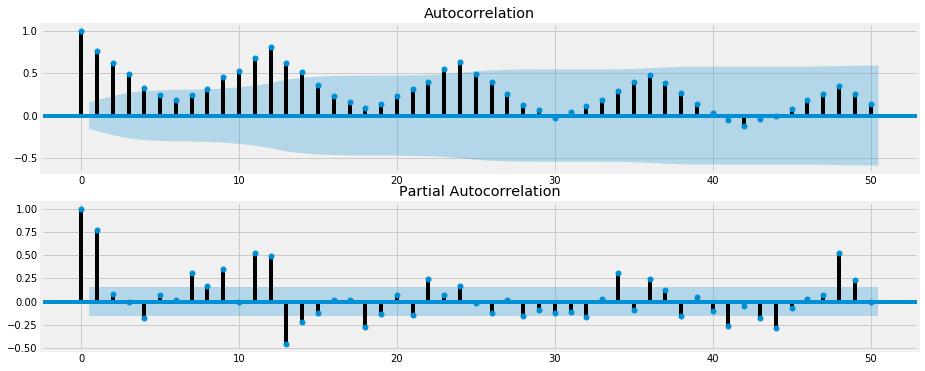

In [5]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(14,6), sharex=False, sharey=False)
ax1 = plot_acf(df, lags=50, ax=ax1)
ax2 = plot_pacf(df, lags=50, ax=ax2)
plt.show()

### Determine rolling statistics

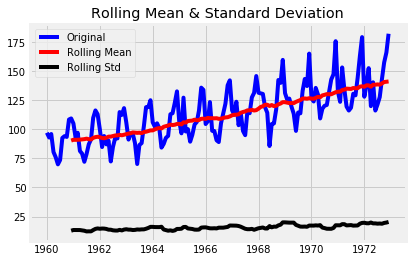

In [6]:

#Determing rolling statistics
rolmean = pd.Series(df['Monthly beer production']).rolling(window=12).mean()
rolstd = pd.Series(df['Monthly beer production']).rolling(window=12).std()

#Plot rolling statistics:
orig = plt.plot(df['Monthly beer production'], color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

### Dickey fuller test and stationary data

In [7]:
from statsmodels.tsa.stattools import adfuller
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(df['Monthly beer production'])
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                   0.855123
p-value                          0.992476
#Lags Used                      11.000000
Number of Observations Used    144.000000
Critical Value (1%)             -3.476598
Critical Value (5%)             -2.881829
Critical Value (10%)            -2.577589
dtype: float64


In [8]:
df_diff = df.diff().diff(12)
df_diff.dropna(inplace=True)
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(df_diff['Monthly beer production'])

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -4.669501
p-value                          0.000096
#Lags Used                      12.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


### Transformed data

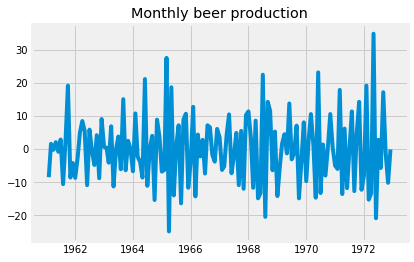

In [9]:
plt.plot(df_diff['Monthly beer production'])
plt.title('Monthly beer production')
plt.savefig('diffplot')
plt.show()

### Observe the correlation

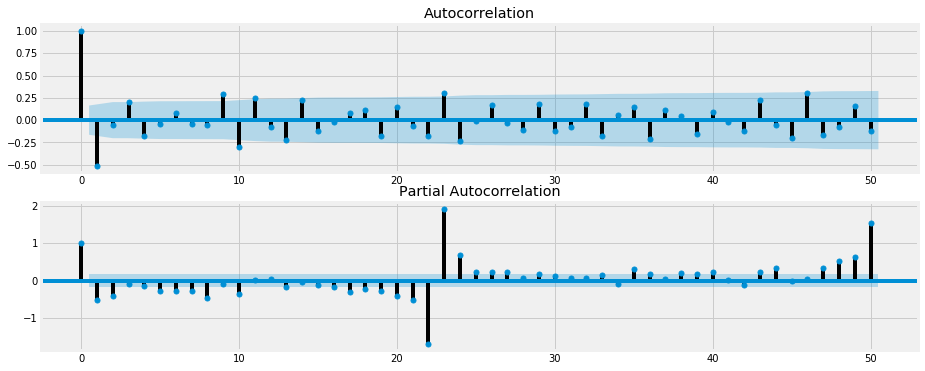

In [10]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(14,6), sharex=False, sharey=False)
ax1 = plot_acf(df_diff, lags=50, ax=ax1)
ax2 = plot_pacf(df_diff, lags=50, ax=ax2)
plt.savefig('acfpacf2')
plt.show()

### Arima model

In [ ]:
#pip install pmdarima
import pmdarima as pm
model = pm.auto_arima(df['Monthly beer production'],d=1, D=3,
                      seasonal=True, m=12, trend='c', 
                      start_p=0, start_q=0, max_order=6, test='adf', stepwise=True, trace=True)

print(model.aic())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,3,1)[12]             : AIC=1041.898, Time=2.02 sec
 ARIMA(0,1,0)(0,3,0)[12]             : AIC=1086.510, Time=0.22 sec
 ARIMA(1,1,0)(1,3,0)[12]             : AIC=1006.529, Time=1.34 sec
 ARIMA(0,1,1)(0,3,1)[12]             : AIC=inf, Time=2.99 sec
 ARIMA(1,1,0)(0,3,0)[12]             : AIC=1046.710, Time=0.42 sec
 ARIMA(1,1,0)(2,3,0)[12]             : AIC=1008.373, Time=2.91 sec
 ARIMA(1,1,0)(1,3,1)[12]             : AIC=1007.986, Time=1.79 sec
 ARIMA(1,1,0)(0,3,1)[12]             : AIC=inf, Time=2.56 sec
 ARIMA(1,1,0)(2,3,1)[12]             : AIC=1009.293, Time=7.34 sec
 ARIMA(0,1,0)(1,3,0)[12]             : AIC=1043.987, Time=0.79 sec
 ARIMA(2,1,0)(1,3,0)[12]             : AIC=979.906, Time=2.13 sec
 ARIMA(2,1,0)(0,3,0)[12]             : AIC=1037.032, Time=0.77 sec
 ARIMA(2,1,0)(2,3,0)[12]             : AIC=979.401, Time=3.63 sec


In [ ]:
print(model.summary())

### Train data

In [ ]:
#divide into train and validation set
train = df[:int(0.80*(len(df)))]
test = df[int(0.80*(len(df))):]

#plotting the data
train['Monthly beer production'].plot()
test['Monthly beer production'].plot()

### Sarima model & training

In [ ]:
import statsmodels.api as sm
model = SARIMAX(train['Monthly beer production'],order=(2,1,3),seasonal_order=(1,1,1,12),enforce_invertibility=False)
results = model.fit()
results.summary()

### Model validation

In [ ]:
results.plot_diagnostics(figsize=(16, 8))
plt.savefig('modeldiagnostics')
plt.show()

### Forecast vs real data

In [ ]:
forecast_object = results.get_forecast(steps=len(test))

mean = forecast_object.predicted_mean

conf_int = forecast_object.conf_int()

dates = mean.index

plt.figure(figsize=(16,8))

# Plot past sales
plt.plot(df.index, df, label='real')

# Plot the prediction means as line
plt.plot(dates, mean, label='predicted')

# Shade between the confidence intervals
plt.fill_between(dates, conf_int.iloc[:,0], conf_int.iloc[:,1],
alpha=0.2)

# Plot legend and show figure
plt.legend()
plt.savefig('predtest')
plt.show()

### Compare predictions against real data

In [ ]:
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(1,1,0)(0,1,1,12) Predictions')
# Compare predictions to expected values
for i in range(len(predictions)):
    print(f"predicted={predictions[i]:<11.10}, expected={test['Monthly beer production'][i]}")

In [ ]:

# Plot predictions against known values
title = 'Monthly beer production'
ax = test['Monthly beer production'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
#ax.set(xlabel=xlabel, ylabel=ylabel);

### Test accuracy

In [ ]:
r2_score(test['Monthly beer production'], predictions)*100

In [ ]:
evaluation_results = pd.DataFrame({'r2_score': r2_score(test['Monthly beer production'], predictions)}, index=[0])
evaluation_results['mean_absolute_error'] = mean_absolute_error(test['Monthly beer production'], predictions)
evaluation_results['mean_squared_error'] = mean_squared_error(test['Monthly beer production'], predictions)
evaluation_results['mean_absolute_percentage_error'] = np.mean(np.abs(predictions - test['Monthly beer production'])/np.abs(test['Monthly beer production']))*100 

evaluation_results

### Forecast

In [ ]:
pred_f = results.get_forecast(steps=130)
pred_ci = pred_f.conf_int()
ax = df.plot(label='Monthly beer production', figsize=(14, 7))
pred_f.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Monthly beer production')
plt.legend()
plt.show()

In [ ]:
#df = pd.read_csv('monthly-beer-production-in-austr.csv')
#df['Date'] = pd.to_datetime(df['Month'])
#df = df.drop('Month',1)
#df = df[df.Date > '1959-12-01']
#df = df[df.Date < '1985-01-01']
#df.set_index('Date', inplace=True)